In [138]:
import random
import numpy as np
import copy
from tabulate import tabulate
from typing import List
from scipy.stats import norm

def sphere(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2)

def weierstrass(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = len(x)
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result

def weierstrass2(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = 25
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result
def rosenbrock(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def schwefel(x, shift=None):
    if shift is not None:
        x = x - shift
    return abs(418.9829*len(x)-np.sum(x * np.sin(np.sqrt(np.abs(x)))))

def griewank(x, shift=None):
    if shift is not None:
        x = x - shift
    part1 = np.sum(x**2)/4000
    part2 = np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1))))
    return 1 + part1 - part2

def rastrigin(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2 - 10 * np.cos(2 * np.pi * x) + 10)

def ackley(x, shift=None):
    if shift is not None:
        x = x - shift
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x) / n)) + 20 + np.exp(1)

In [139]:
from cmaes import CMA
class SubPopulation:

    def __init__(self, fitness_function, shift_vector, low, high):
        self.fitness_function = fitness_function
        self.shift_vector = shift_vector
        self.limit = [low, high]
        self.generation = [np.array([random.uniform(low, high) for x in range(50)]) for y in range(100)]
        self.generation.sort(key = lambda x: self.fitness(x))
        self.covariance = np.cov(np.array(copy.copy(self.generation[0:50])).T)
        self.mean = np.mean(np.array(copy.copy(self.generation[0:50])), axis=0)
        self.variance = np.var(np.array(copy.copy(self.generation[0:50])), axis=0)
        self.improverment = 1
        self.eval = 1
        self.optimizer = CMA(mean=self.mean, sigma = 2, population_size=100)
        solutions = []
        for x in self.generation:
            solutions.append((x, self.fitness(x)))
        self.optimizer.tell(solutions)

    def fitness(self, x):    
        result = min(1e32, self.fitness_function(x, np.array(self.shift_vector)))
        return result
        
    def update_population(self, next_generation):
        self.generation += next_generation
        self.generation.sort(key = lambda x: self.fitness(x))
        self.generation = self.generation[0:100]
        solutions = []
        for x in self.generation:
            solutions.append((x, self.fitness(x)))
        self.optimizer.tell(solutions)

    def generate_offspring(self):
        offspring = []
        for _ in range(self.optimizer.population_size):
            x = self.optimizer.ask()
            for k in range(len(x)):
                x[k] = min(x[k], self.limit[1])
                x[k] = max(x[k], self.limit[0])
            offspring.append(x)   
        return offspring

In [140]:
class Framework:

    def __init__(self, fitness_functions, shift_vectors, lows, highs, gama) -> None:
        self.multi_task : List[SubPopulation] = []
        for k in range(len(fitness_functions)):
            self.multi_task.append(SubPopulation(fitness_functions[k], shift_vectors[k], lows[k], highs[k]))
        self.epsilon : List[float] = [1 for x in range(len(self.multi_task))]
        self.gama = gama
    
    def generate_next_generation(self):
        offsprings = []
        total_offsprings = []
        for k in range(len(self.multi_task)):
            new_pop = self.multi_task[k].generate_offspring()
            offsprings.append(new_pop)
            total_offsprings += new_pop

        for k in range(len(self.multi_task)):
            rmp = random.uniform(0,1)
            if rmp<self.multi_task[k].improverment/self.multi_task[k].eval:
                next_generation = []
                selected = set()
                while len(next_generation) < self.gama:
                    num = random.randint(0, len(total_offsprings)-1)
                    if num not in selected:
                        next_generation.append(total_offsprings[num])
                        selected.add(num)
                next_generation.sort(key= lambda x: self.multi_task[k].fitness(x))
                self.multi_task[k].update_population(next_generation)
                if self.multi_task[k].fitness(self.multi_task[k].generation[10])>self.multi_task[k].fitness(next_generation[0]):
                    self.multi_task[k].improverment+=1
            else:
                self.multi_task[k].update_population(offsprings[k])
            
            self.multi_task[k].eval+=1
        

In [141]:
finess_functions = []
shift_vectors = []
lows = []
highs = []

#Sphere 1:
finess_functions.append(sphere)
shift_vectors.append([0 for x in range(50)])
lows.append(-100)
highs.append(100)

#Sphere 2:
finess_functions.append(sphere)
shift_vectors.append([80 for x in range(50)])
lows.append(-100)
highs.append(100)

#Sphere 3:
finess_functions.append(sphere)
shift_vectors.append([-80 for x in range(50)])
lows.append(-100)
highs.append(100)

#Weierstrass 1:
finess_functions.append(weierstrass2)
shift_vectors.append([-0.4 for x in range(50)])
lows.append(-0.5)
highs.append(0.5)

#Rosenbrock:
finess_functions.append(rosenbrock)
shift_vectors.append([0 for x in range(50)])
lows.append(-50)
highs.append(50)

#Ackley:
finess_functions.append(ackley)
shift_vectors.append([40 for x in range(50)])
lows.append(-50)
highs.append(50)

#Weierstrass 2:
finess_functions.append(weierstrass)
shift_vectors.append([0.4 for x in range(50)])
lows.append(-0.5)
highs.append(0.5)

#Schwefel:
finess_functions.append(schwefel)
shift_vectors.append([420.9687 for x in range(50)])
lows.append(-500)
highs.append(500)

#Griewank:
finess_functions.append(griewank)
shift_vectors.append([-80 for x in range(25)]+[80 for x in range(25)])
lows.append(-100)
highs.append(100)

#Rastrign:
finess_functions.append(rastrigin)
shift_vectors.append([40 for x in range(25)]+[-40 for x in range(25)])
lows.append(-50)
highs.append(50)


In [142]:
model = Framework(finess_functions, shift_vectors, lows, highs, 50)
history = []
for x in range(1000):
    model.generate_next_generation()
    tmp = []
    for k in range(len(model.multi_task)):
        tmp.append(model.multi_task[k].fitness(model.multi_task[k].generation[0]))
    history.append(tmp)

c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\cmaes\_cma.py:352: RuntimeWarning: overflow encountered in exp
  self._sigma *= np.exp(
c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\cmaes\_cma.py:352: RuntimeWarning: overflow encountered in scalar multiply
  self._sigma *= np.exp(


In [143]:
headers = [f"T{i+1}" for i in range(len(history[0]))]
table = tabulate(history, headers=headers, tablefmt='grid')
print(table)

+------------+------------------+------------------+---------+-----------+---------+---------+------------+------------+---------+
|         T1 |               T2 |               T3 |      T4 |        T5 |      T6 |      T7 |         T8 |         T9 |     T10 |
+============+==================+==================+=========+===========+=========+=========+============+============+=========+
| 9.01826    | 306209           | 275701           | 31.8836 | 1036.34   | 20      | 56.907  | 237.701    | 77.2596    | 80076.1 |
+------------+------------------+------------------+---------+-----------+---------+---------+------------+------------+---------+
| 9.01826    | 265241           | 275701           | 27.3665 |  980.836  | 20      | 56.907  | 237.701    | 72.25      | 80076.1 |
+------------+------------------+------------------+---------+-----------+---------+---------+------------+------------+---------+
| 9.01826    | 265241           | 275701           | 27.3665 |  915.928  | 19.9996 

In [144]:
for x in range(1000):
    model.generate_next_generation()
    tmp = []
    for k in range(len(model.multi_task)):
        tmp.append(model.multi_task[k].fitness(model.multi_task[k].generation[0]))
    history.append(tmp)

In [145]:
headers = [f"T{i+1}" for i in range(len(history[0]))]
table = tabulate(history, headers=headers, tablefmt='grid')
print(table)

+-------------+------------------+------------------+---------+-----------+----------+---------+------------+------------+---------+
|          T1 |               T2 |               T3 |      T4 |        T5 |       T6 |      T7 |         T8 |         T9 |     T10 |
+=============+==================+==================+=========+===========+==========+=========+============+============+=========+
| 9.01826     | 306209           | 275701           | 31.8836 | 1036.34   | 20       | 56.907  | 237.701    | 77.2596    | 80076.1 |
+-------------+------------------+------------------+---------+-----------+----------+---------+------------+------------+---------+
| 9.01826     | 265241           | 275701           | 27.3665 |  980.836  | 20       | 56.907  | 237.701    | 72.25      | 80076.1 |
+-------------+------------------+------------------+---------+-----------+----------+---------+------------+------------+---------+
| 9.01826     | 265241           | 275701           | 27.3665 |  915.

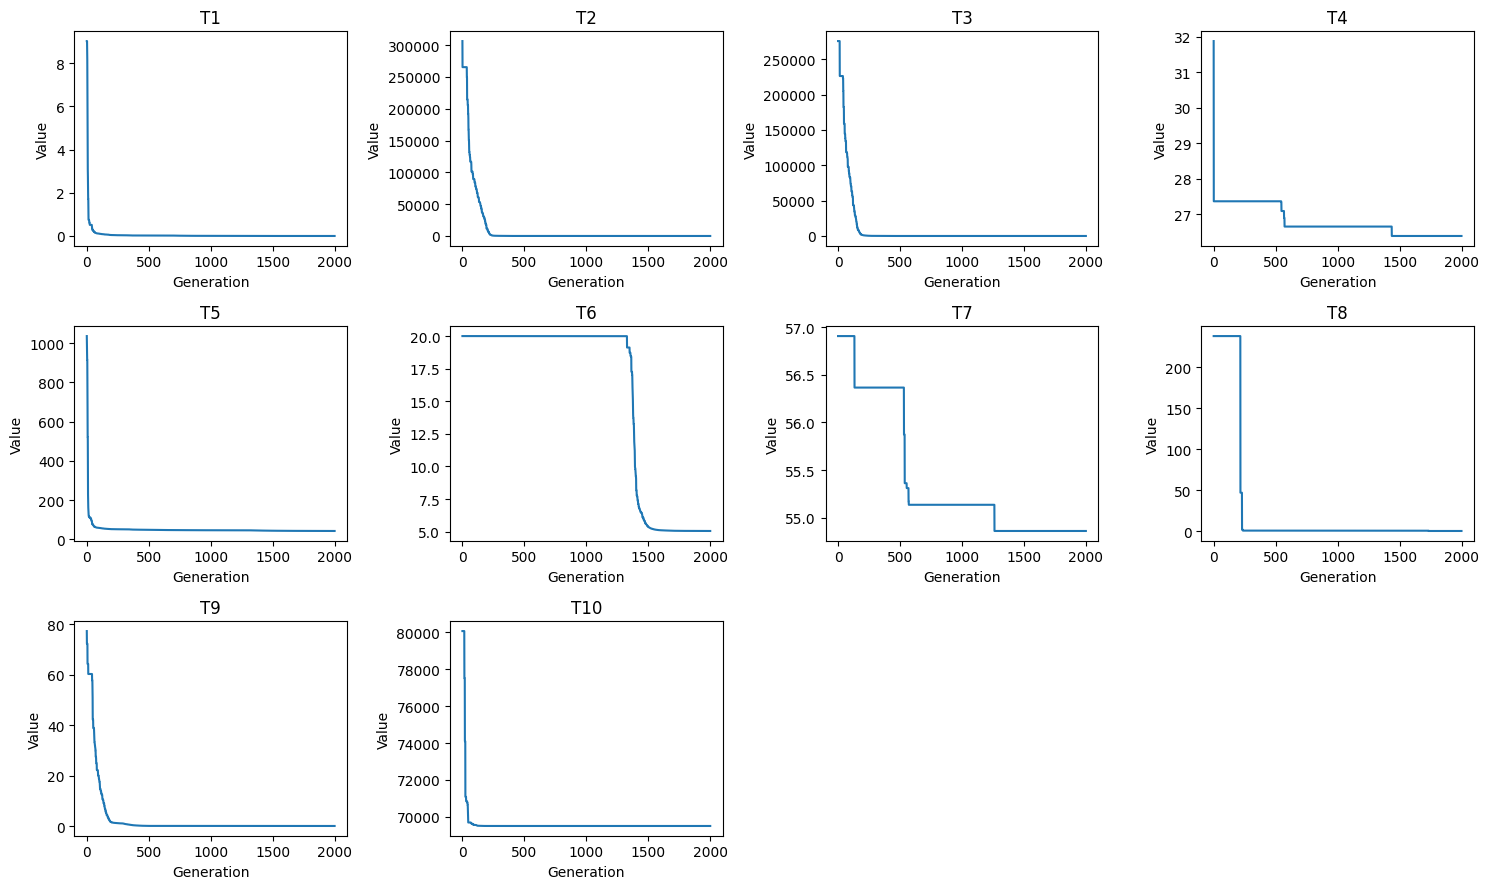

In [146]:
import matplotlib.pyplot as plt

def plot_functions(history):
    num_functions = len(history[0])  # Số lượng hàm
    num_points = len(history)  # Số lượng điểm
    num_plots_per_row = 4  # Số lượng đồ thị trên mỗi hàng

    num_rows = (num_functions + num_plots_per_row - 1) // num_plots_per_row

    # Tạo subplot với kích thước phù hợp
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows*3))

    for j in range(num_functions):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].plot(range(num_points), history[:, j])
        axs[row_index, col_index].set_title(f'T{j+1}')
        axs[row_index, col_index].set_xlabel('Generation')
        axs[row_index, col_index].set_ylabel('Value')

    # Nếu số lượng hàm không phải là bội số của num_plots_per_row, ẩn các subplot không cần thiết
    for j in range(num_functions, num_rows*num_plots_per_row):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()


plot_functions(np.array(history))